In [82]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, RationalQuadratic
from scipy.stats import norm


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))



Database connection ok


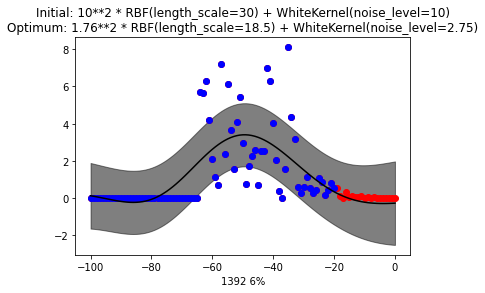

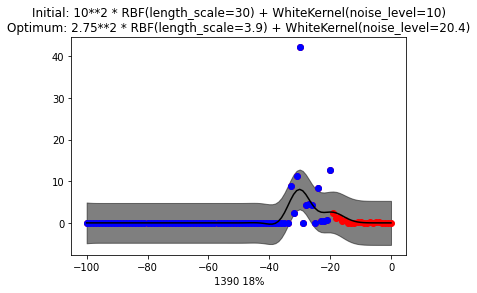

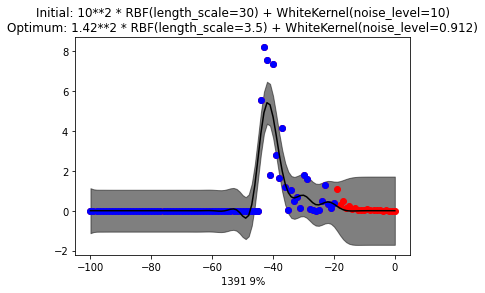

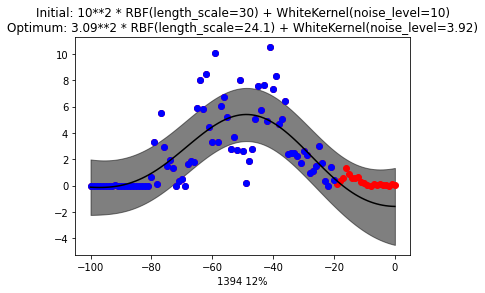

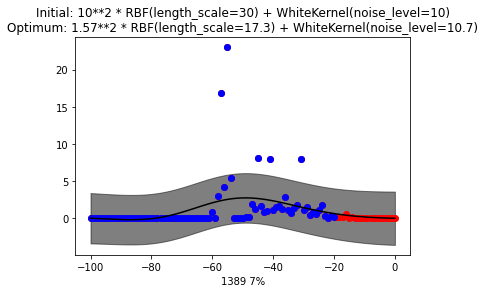

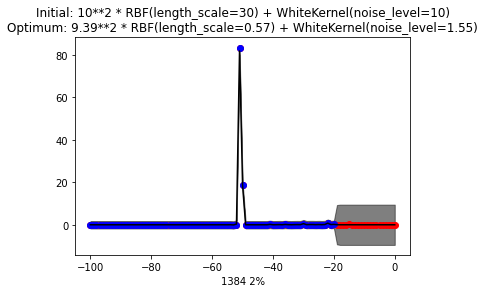

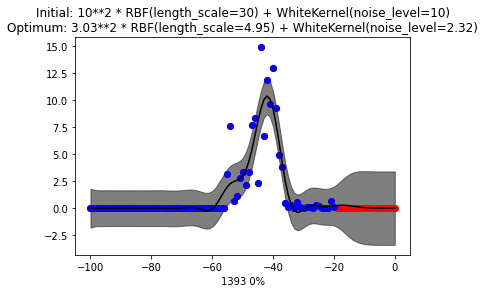

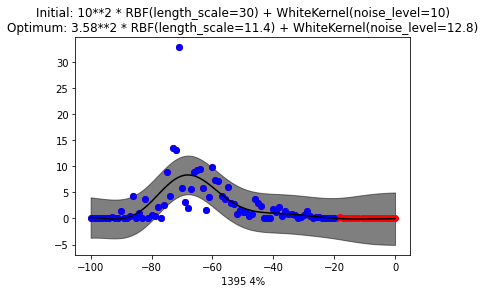

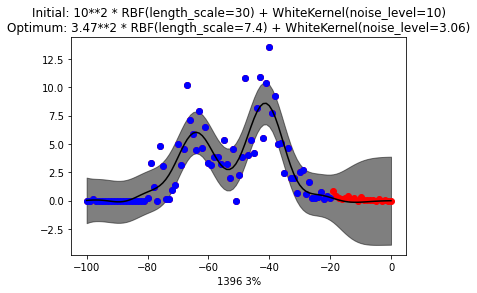

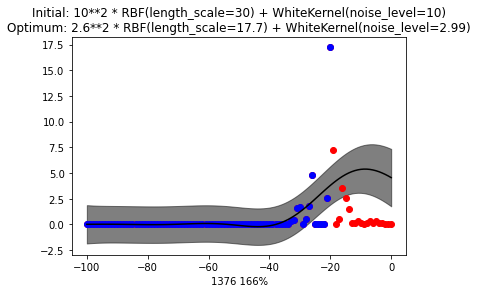

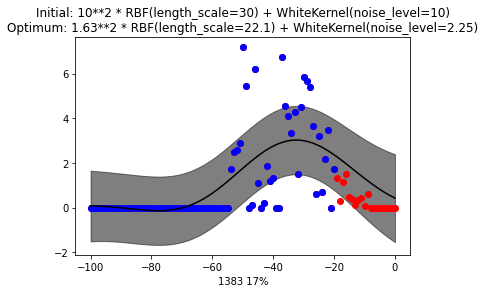

In [87]:
# Dynamic whole ship cable quantities
# Predictors:
# Current quantity intervals, past 10 week time series
# Algorithms:
# Gaussian process regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE p.prototype=1"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall())
ships = data[:, 0]
gt = data[:, 1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

for ship in ships:
    start, end = -100, 0
    cut = -20
    cursor.execute(
        "SELECT wk, cables FROM progress WHERE"
        " wk >= {} AND wk <= {} AND project_id={} ORDER BY wk"
        .format(start, end, ship)
    )
    data = np.array(cursor.fetchall())
    X = data[:, 0].reshape(-1, 1)
    y = (data[:, -1]/10000)

# run
    plt.figure()
    cut_args = np.argwhere(X[:, 0]<=cut)[:, 0]

    kernel = 100.0 * RBF(length_scale=30.0, length_scale_bounds=(1e-1, 1e3)) \
        + WhiteKernel(noise_level=10, noise_level_bounds=(1e-10, 1e+10))
    gp = GaussianProcessRegressor(kernel=kernel,
                                alpha=0.0).fit(X[cut_args], y[cut_args])

    y_mean, y_cov = gp.predict(X, return_cov=True)
    plt.plot(X, y_mean, 'k')
    plt.fill_between(X[:, 0], y_mean - np.sqrt(np.diag(y_cov)),
                    y_mean + np.sqrt(np.diag(y_cov)),
                    alpha=0.5, color='k')
    plt.scatter(X[:, 0], y, c='r')
    plt.scatter(X[cut_args], y[cut_args], c='b')
    trained_kernel = gp.kernel_
    plt.title("Initial: %s\nOptimum: %s"
            % (kernel, trained_kernel))
    cut_args = np.argwhere(X[:, 0]>=cut)
    pred = y_mean.sum()
    real = y.sum()
    err = abs(pred-real)/real
    plt.xlabel(str(ship) + ' ' + str(round(100*err)) + '%')
